###1. 라이브러리 불러오기

In [1]:
import os
import shutil
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


###2. 데이터셋 정의 - 비오염

In [3]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6232493].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6384109..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708]

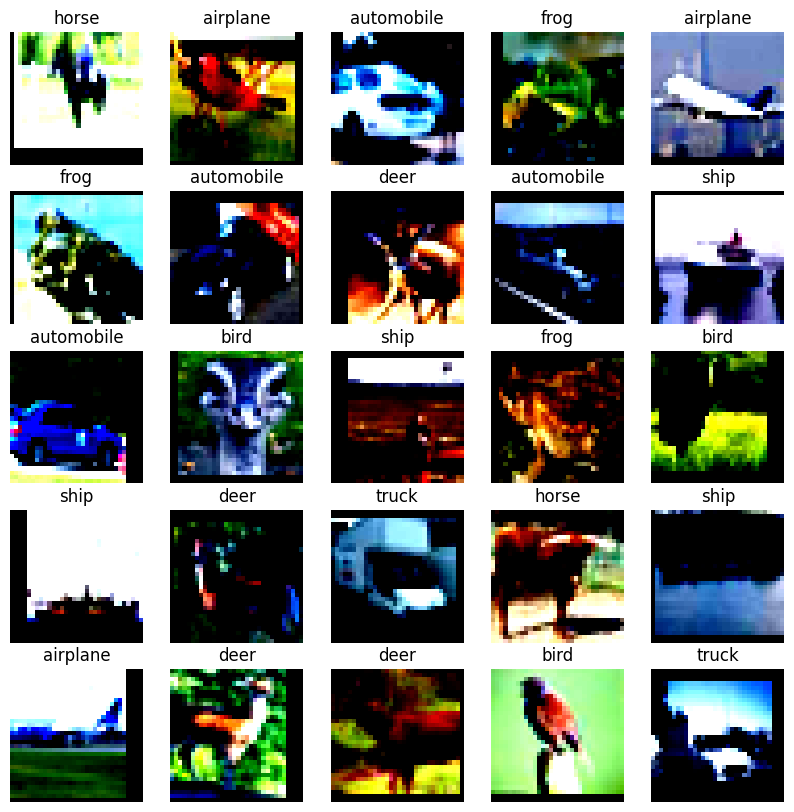

In [6]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt         

#torch 때문에 numpy 1.26.4 사용

classes = train_set.classes

batch = next(iter(train_loader))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

###3. 신경망 코딩 - ResNet50

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [8]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

###4. 신경망 학습과 테스트 진행

In [9]:
# Evaluate function
def evaluate(model, device, test_loader):
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

In [10]:
# Train and evaluate function
def train_and_evaluate(model, device, train_loader, test_loader, epochs=5):
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

  accuracies = []

  for epoch in range(epochs):
    running_loss = 0.0
    data_iterator = iter(train_loader)
    for inputs, labels in data_iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

    accuracy = evaluate(model, device, test_loader)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}%')

  return accuracies

In [11]:
acc_res = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=5)

[Epoch 1] loss: 1.602
Accuracy: 47.81%
[Epoch 2] loss: 1.446
Accuracy: 58.30%
[Epoch 3] loss: 1.066
Accuracy: 66.19%
[Epoch 4] loss: 0.874
Accuracy: 71.14%
[Epoch 5] loss: 0.746
Accuracy: 71.17%


다른 신경망 모델

In [13]:
#VGG16모델
class VGG16(nn.Module):
  '''
  Define a VGG16 model class by inheriting PyTorch's nn.Module class
  '''
  def __init__(self):
    super(VGG16, self).__init__()
    '''
    Define sequential containers containing multiple layers sequentially
    '''
    self.features = nn.Sequential(

      # Conv2d - BatchNorm2d - ReLU - Conv2d - BatchNorm2d - ReLU - MaxPool2d (Utilize nn module)
      # Check the additional layer ReLU for activation
      # kernel size=3, padding=1

      # Conv Block 1
      nn.Conv2d(3, 64, kernel_size=3, padding=1), # input channel=3, outputchannel=64
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # Conv Block 2
      # The input channel becomes the output of Conv Block 1
      # The output channel becomes doble to input channel
      nn.Conv2d(64, 128, kernel_size=3, padding=1), # input channel=3, outputchannel=64
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # Conv Block 3
      nn.Conv2d(128, 256, kernel_size=3, padding=1), # input channel=3, outputchannel=64
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # Conv Block 4
      nn.Conv2d(256, 512, kernel_size=3, padding=1), # input channel=3, outputchannel=64
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # Conv Block 5
      # Keep input and output channel sizes the same
      nn.Conv2d(512, 512, kernel_size=3, padding=1), # input channel=3, outputchannel=64
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    '''
    Define a sequential container containing several layers that make up the part of the classifier
    '''
    self.classifier = nn.Sequential(

      nn.Dropout(), # The dropout layer randomly excludes neurons to prevent overfitting
      nn.Linear(512 * 1 * 1, 4096),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Linear(4096, 10)
      )

  def forward(self, x):
    '''
    Calculate the output by propagating input data through the model
    '''
    # x = self.features
    # x = convert feature to 2d tensor
    # x = self classifiers
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)

    return x

In [14]:
model_V16 = VGG16().to(device)

In [15]:
acc_V16 = train_and_evaluate(model_V16, device, train_loader, test_loader, epochs=5)

[Epoch 1] loss: 1.884
Accuracy: 41.07%
[Epoch 2] loss: 1.752
Accuracy: 42.39%
[Epoch 3] loss: 1.443
Accuracy: 53.19%
[Epoch 4] loss: 1.212
Accuracy: 57.81%
[Epoch 5] loss: 1.058
Accuracy: 62.92%


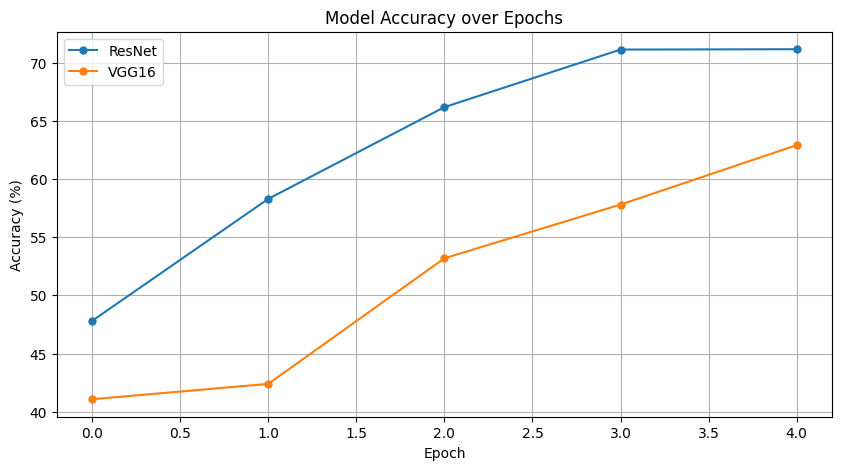

In [16]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet')
plt.plot(acc_V16, marker='o', linestyle='-', markersize=5, label='VGG16')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

데이터의 오염을 통한 학습 효율 변화

In [18]:
'''
#corrupting 일부
import random
from PIL import Image

def pixelblending(train_set):
  for i in range(int(len(train_set)/10)):
    background_image, background_label = train_set[i]
    overlay_image, overlay_label = random.choice(train_set)

    # Convert tensors to PIL Images
    background_image = transforms.ToPILImage()(background_image)
    overlay_image = transforms.ToPILImage()(overlay_image)

    x, y = 0, 0
    alpha = 0.1

    # Convert overlay_image to RGBA if it's not already
    overlay_image = overlay_image.convert("RGBA")

    # Get pixel data and apply alpha
    overlay_data = list(overlay_image.getdata())
    new_data = [(item[0], item[1], item[2], int(item[3] * alpha)) for item in overlay_data]

    # Update overlay_image with the new data
    overlay_image.putdata(new_data)

    # Paste the overlay onto the background
    background_image.paste(overlay_image, (x, y), overlay_image)

    # Convert the PIL Image back to a tensor
    background_image = transforms.ToTensor()(background_image)

    train_set.data[i] = torch.from_numpy(background_image.permute(1, 2, 0).numpy()) # Update the data in train_set

  return train_set
  '''

'\n#corrupting 일부\nimport random\nfrom PIL import Image\n\ndef pixelblending(train_set):\n  for i in range(int(len(train_set)/10)):\n    background_image, background_label = train_set[i]\n    overlay_image, overlay_label = random.choice(train_set)\n\n    # Convert tensors to PIL Images\n    background_image = transforms.ToPILImage()(background_image)\n    overlay_image = transforms.ToPILImage()(overlay_image)\n\n    x, y = 0, 0\n    alpha = 0.1\n\n    # Convert overlay_image to RGBA if it\'s not already\n    overlay_image = overlay_image.convert("RGBA")\n\n    # Get pixel data and apply alpha\n    overlay_data = list(overlay_image.getdata())\n    new_data = [(item[0], item[1], item[2], int(item[3] * alpha)) for item in overlay_data]\n\n    # Update overlay_image with the new data\n    overlay_image.putdata(new_data)\n\n    # Paste the overlay onto the background\n    background_image.paste(overlay_image, (x, y), overlay_image)\n\n    # Convert the PIL Image back to a tensor\n    backgr

In [19]:
#데이터 오염 함수 정의
import random
from PIL import Image

# One Pixel Attack을 10%의 샘플에 적용하는 함수 정의
def apply_one_pixel_attack(dataset, attack_ratio=0.1):
    """
    CIFAR-10 데이터셋의 일부 샘플에 One Pixel Attack을 가하는 함수입니다.

    Args:
    - dataset: CIFAR-10 데이터셋 객체
    - attack_ratio: 공격할 이미지 비율 (0.1 = 10%)

    Returns:
    - attacked_dataset: 공격이 적용된 새로운 CIFAR-10 데이터셋 (TensorDataset)
    """
    # 전체 이미지와 라벨을 저장할 리스트
    attacked_images = []
    attacked_labels = []

    # 전체 데이터셋의 attack_ratio 비율만큼 공격할 샘플 수 계산
    num_attack_samples = int(attack_ratio * len(dataset))
    attacked_indices = random.sample(range(len(dataset)), num_attack_samples)  # 무작위 인덱스 선택

    for idx in range(len(dataset)):
        # 이미지와 라벨을 가져오기
        image, label = dataset[idx]

        if idx in attacked_indices:
            # 이미지 복사 후 공격 수행
            attacked_image = image.clone()

            # 랜덤으로 픽셀 위치 선택
            x = random.randint(0, attacked_image.shape[1] - 1)  # 높이
            y = random.randint(0, attacked_image.shape[2] - 1)  # 너비

            # 무작위 RGB 값 설정하여 공격
            attacked_image[:, x, y] = torch.rand(3)  # RGB 값 무작위 설정 (0~1)
        else:
            # 공격하지 않은 이미지는 원본을 그대로 사용
            attacked_image = image

        # 리스트에 추가
        attacked_images.append(attacked_image)
        attacked_labels.append(label)

    # 리스트를 텐서로 변환
    attacked_images_tensor = torch.stack(attacked_images)
    attacked_labels_tensor = torch.tensor(attacked_labels)

    # TensorDataset으로 묶어 새로운 데이터셋 반환
    attacked_dataset = TensorDataset(attacked_images_tensor, attacked_labels_tensor)
    return attacked_dataset

In [20]:
train_set_corrupted = apply_one_pixel_attack(train_set, attack_ratio=0.2)

In [21]:
#dataloader 생성
train_loader_corrupted = DataLoader(dataset=train_set_corrupted, batch_size=64, shuffle=True)

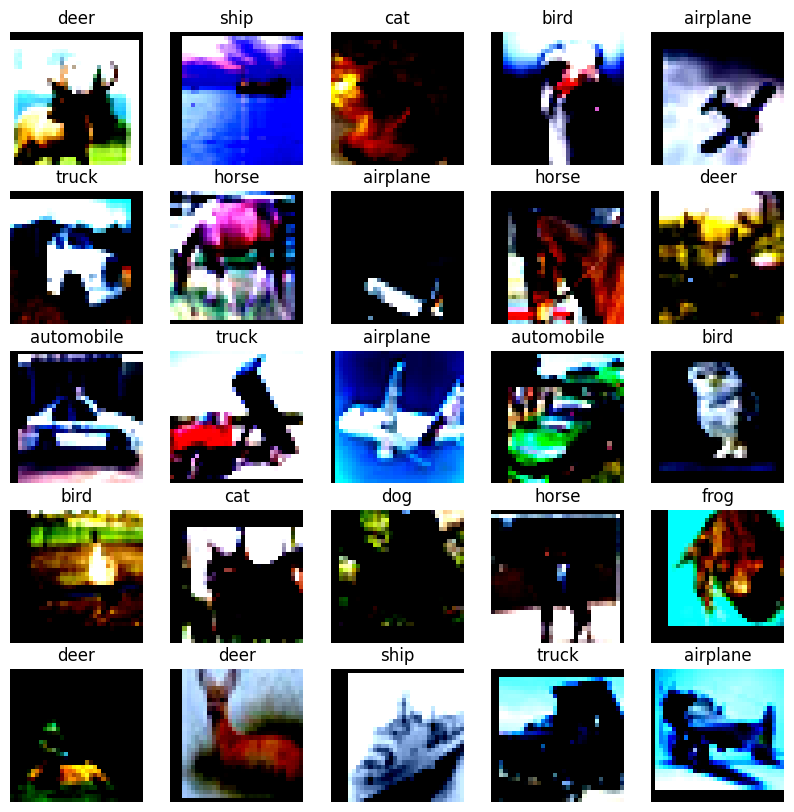

In [ ]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = train_set.classes

batch = next(iter(train_loader_corrupted))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

In [22]:
#초기 신경망 생성 및 장치에 저장
model_res_c = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_V16_c = VGG16().to(device)

In [23]:
acc_res_c = train_and_evaluate(model_res_c, device, train_loader_corrupted, test_loader, epochs=5)

[Epoch 1] loss: 1.597
Accuracy: 54.09%
[Epoch 2] loss: 1.237
Accuracy: 60.17%
[Epoch 3] loss: 0.974
Accuracy: 65.42%
[Epoch 4] loss: 0.814
Accuracy: 71.16%
[Epoch 5] loss: 0.674
Accuracy: 72.57%


In [24]:
acc_V16_c = train_and_evaluate(model_V16_c, device, train_loader_corrupted, test_loader, epochs=5)

[Epoch 1] loss: 1.897
Accuracy: 36.67%
[Epoch 2] loss: 1.651
Accuracy: 34.40%
[Epoch 3] loss: 1.396
Accuracy: 58.18%
[Epoch 4] loss: 1.166
Accuracy: 60.28%
[Epoch 5] loss: 1.016
Accuracy: 64.70%


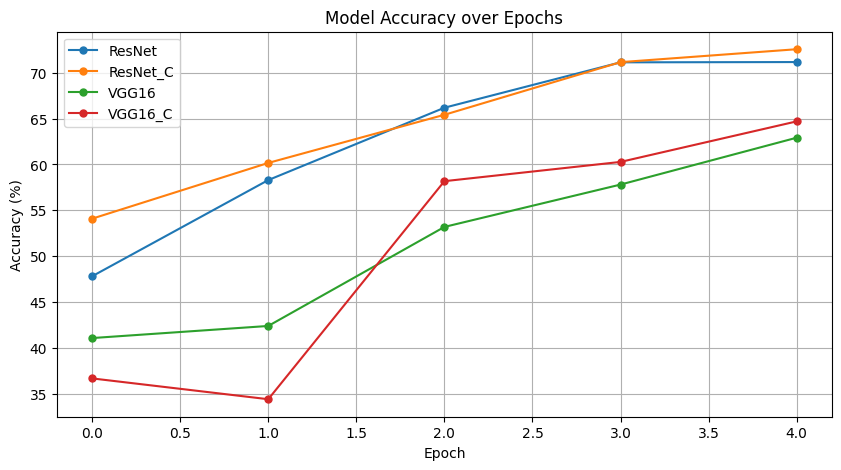

In [25]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet')
plt.plot(acc_res_c, marker='o', linestyle='-', markersize=5, label='ResNet_C')
plt.plot(acc_V16, marker='o', linestyle='-', markersize=5, label='VGG16')
plt.plot(acc_V16_c, marker='o', linestyle='-', markersize=5, label='VGG16_C')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()